In [11]:
from azure.storage.blob import BlobServiceClient, ContainerClient, BlobPrefix
import cv2
import imageio.v3 as iio
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from torchviz import make_dot
from copy import deepcopy

# Get the directory of the current script file
os.chdir(r'C:\Users\Ecko_\exjobb_jupyter')
#print(os.getcwd())

### Blob Storage Set-up

### Importing 

In [12]:
STORAGEACCOUNTURL = "https://exjobbssl1863219591.blob.core.windows.net"
STORAGEACCOUNTKEY = "PuL1QY8bQvIyGi653lr/9CPvyHLnip+cvsu62YAipDjB7onPDxfME156z5/O2NwY0PRLMTZc86/6+ASt5Vts8w=="
CONTAINERNAME = "exjobbssl"
FOLDERNAME = "UCF-101/Diving/" #Temporary during the development phase
#BLOBNAME = "UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi"

blob_service_client_instance = BlobServiceClient(
    account_url=STORAGEACCOUNTURL, credential=STORAGEACCOUNTKEY)

# CALL SPECIFIC BLOB
# #blob_client_instance = blob_service_client_instance.get_blob_client(
#    CONTAINERNAME, BLOBNAME, snapshot=None)
#blob_data = blob_client_instance.download_blob()
#data = blob_data.readall()

container_client_instance = blob_service_client_instance.get_container_client(CONTAINERNAME)
#blob_list = container_client_instance.list_blobs()

### Load Videos Into Memory

In [13]:
class BlobSamples(object):
    def __init__(self):
        self.depth = 0
        self.indent = "  "

    def list_blobs_hierarchical(self, container_client: ContainerClient, prefix):
        for blob in container_client_instance.walk_blobs(name_starts_with=prefix, delimiter='/'):
            if isinstance(blob, BlobPrefix):
                # Indentation is only added to show nesting in the output
                print(f"{self.indent * self.depth}{blob.name}")
                self.depth += 1
                self.list_blobs_hierarchical(container_client_instance, prefix=blob.name)    
                self.depth -= 1
                #print('hi')
            else:
                print(f"{self.indent * self.depth}{blob.name}")

    def load_videos_into_memory(self, blob_service_client: BlobServiceClient, container_name, folder_name, videos_loaded):
        container_client = blob_service_client.get_container_client(container=container_name)

        blob_list = container_client.list_blobs(name_starts_with=folder_name)

        videos = []
        counter = 0  # Add a counter
        for blob in blob_list:
            if counter >= videos_loaded:  # Break the loop after loading 5 videos
                break
            blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob.name)
            video_data = blob_client.download_blob().readall()

            # Create a dictionary for the video
            video = {
                'path': blob.name,  # The path of the video
                'data': video_data  # The bytes data of the video
            }

            videos.append(video)
            counter += 1  # Increment the counter
        return videos

# LIST ALL FOLDERS – Usage of the hierarchical list_blobs function
#sample = BlobSamples()
#sample.list_blobs_hierarchical(container_client_instance, "")

# Usage:
sample = BlobSamples()

videos_loaded = 200
print('loading videos')
videos = sample.load_videos_into_memory(blob_service_client_instance, CONTAINERNAME, FOLDERNAME, videos_loaded)
print('videos loaded')
print("Amount of videos loaded: " + str(len(videos)))

loading videos
videos loaded
Amount of videos loaded: 150


### Read Frame From Blob Storage – OPTIONAL

In [14]:
def read_frames_from_first_n_videos(videos, n):
    for video_data in videos[:n]:  # Only take the first n videos
        frames = iio.imread(video_data, index=None, format_hint=".avi")
        #frames.shape
        # Output:
        #(165 frames, 240x320 pixels, 3 channels)

        frame = frames[0]
        cv2.imshow("image", frame)
        if cv2.waitKey(0) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

# Usage:
amount_of_videos_to_load = 1
#read_frames_from_first_n_videos(videos, amount_of_videos_to_load)

### Prepare Datasets

In [15]:
class PreparedDataset(Dataset):
    def __init__(self, videos, trainval='train'):
        self.video_names_train = []
        self.video_names_test = []
        self.action_labels_train = []
        self.action_labels_test = []
        self.predata_train = []
        self.predata_test = []
        self.videos = videos
        self.trainval = trainval

        # Read the classes file
        with open('classInd.txt', 'r') as f:
            classes = f.readlines()
        classes = [c.strip().split(' ', 1)[1] for c in classes]
        self.class_to_id = {c: i for i, c in enumerate(classes)} #dictionary

        # First, read the paths and labels from the trainlist and testlist files into dictionaries
        train_paths = {}
        test_paths = {}
        with open('trainlist1.txt', 'r') as f:
            for line in f:
                path, label = line.strip().split(' ')
                train_paths[path] = int(label)-1  # Subtract 1 to make the labels 0-indexed
        with open('testlist1.txt', 'r') as f:
            test_paths = {line.strip() for line in f}
        for video in videos:
            path = video['path'][len('UCF-101/'):]  # Remove the 'UCF-101/' prefix from the video path
            video_name = path.split('/')[1].split('.avi')[0].replace('v_', '') #Extracting the name
            if path in train_paths:
                self.video_names_train.append(video_name)
                label = train_paths[path]  # Extract the label from the dictionary
                self.action_labels_train.append(label)
                self.predata_train.append(video)
            elif path in test_paths:
                self.video_names_test.append(video_name)
                class_name = path.split('/')[0]
                label = self.class_to_id[class_name]
                self.action_labels_test.append(label)
                self.predata_test.append(video)

    def __getitem__(self, index):  # https://stackoverflow.com/questions/43627405/understanding-getitem-method-in-python
        if self.trainval == 'train':
            video_name = self.video_names_train[index]
            label = self.action_labels_train[index]
            video = self.predata_train[index]
        else:
            video_name = self.video_names_test[index]
            label = self.action_labels_test[index]
            video = self.predata_test[index]
            
        # Convert the bytes to frames
        #video = iio.imread(video_bytes, index=None, format_hint=".avi")

        return video, label, video_name

    def __len__(self):
        if self.trainval == "train":
            return len(self.predata_train)
        else:
            return len(self.predata_test)

### Train/test Dataset Test

Number of training videos: 105
Number of testing videos: 45


(168, 240, 320, 3)
(148, 240, 320, 3)
(158, 240, 320, 3)
(145, 240, 320, 3)
(155, 240, 320, 3)
(219, 240, 320, 3)


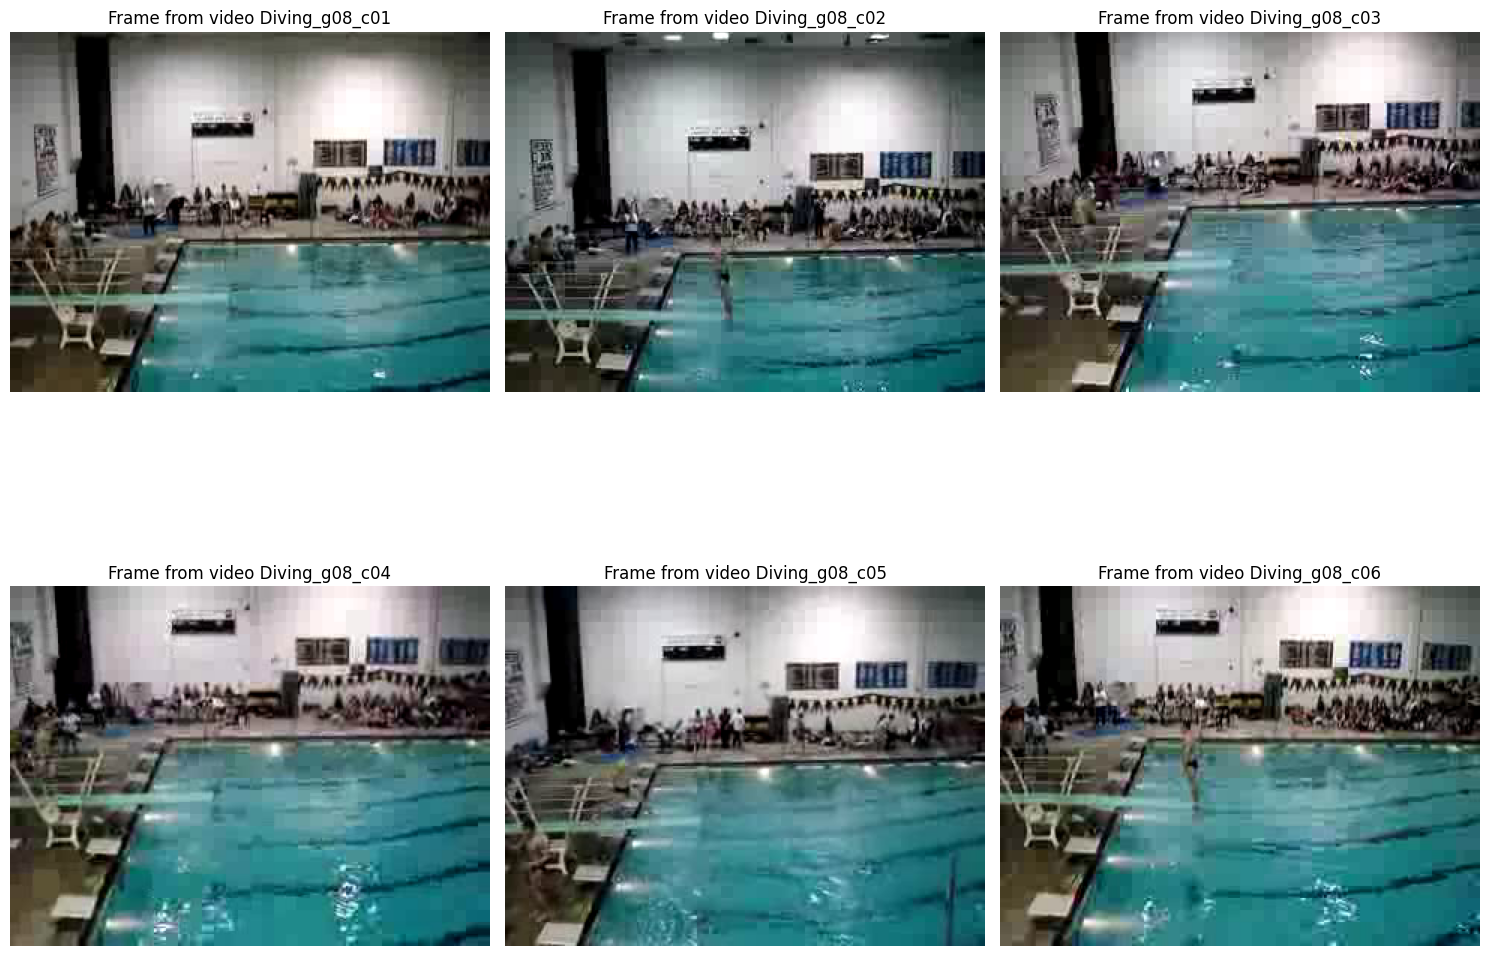

In [16]:
# Initialize the train/test dataset
video_dataset = PreparedDataset(videos, trainval='train')

# Print the first 5 file paths from filelist_train and filelist_test
def test_video_dataset(dataset, n):
    print(f"Number of training videos: {len(dataset.predata_train)}")
    print(f"Number of testing videos: {len(dataset.predata_test)}")

    #print(dataset.actionlabels_train[:15])
    #print(dataset.actionlabels_test[:15])

    #print(dataset.video_names_train[:15])
    #print(dataset.video_names_test[:15])

    fig, axs = plt.subplots(nrows=(n+2)//3, ncols=3, figsize=(15, 5*(n+2)//3))

    # Display the first n videos from the training data
    for i, video_data in enumerate(dataset.predata_train[:n]):  # Only take the first n videos from training data
        frames = iio.imread(video_data['data'], index=None, format_hint=".avi")
        print(frames.shape)
        frame = frames[0]

        # Display the frame using pyplot
        axs[i//3, i%3].imshow(frame)
        axs[i//3, i%3].set_title(f'Frame from video {dataset.video_names_train[i]}')
        axs[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_display = 6
test_video_dataset(video_dataset, amount_of_videos_to_display)

### Image Re-ordering & Preprocessing

In [24]:
class PreprocessedTemporalFourData(Dataset):
    def __init__(self, dataset, trainval='train', mean=[96.5, 96.5, 96.5], imagesize=80):
        self.dataset = dataset
        self.trainval = trainval
        self.mean = mean
        self.imagesize = imagesize
        self.counter = 0 
        
    def __len__(self):
        if self.trainval == 'train':
            return len(self.dataset.predata_train)
        else:
            return len(self.dataset.predata_test)

    def __getitem__(self, index):
        self.counter += 1  # Increment the counter
        #print(f'__getitem__ has been called {self.counter} times')
        video, action_label, video_name = self.get_video_data(index)
        # Read the frames from the video
        frames = iio.imread(video['data'], index=None, format_hint=".avi")
        
        # Compute the optical flow weights for frame selection
        weights, flows = self.compute_optical_flow_weights(frames)
        #print('flows computed')
                
        # Select the frames from the video based on the weights
        indices = np.random.choice(frames.shape[0], size=4, replace=False, p=weights)
        selected_frames = frames[indices]

        # Normalize the indices to their respective order
        order_indices = indices.argsort().argsort()
        #print(order_selected_frames)

        # Create label list for the frame order
        frame_order_label, frames_canonical_order = self.get_frame_order_label(order_indices)
        
        # Preprocess the frames
        preprocessed_frames, uncropped_frames = self.preprocess_frames(selected_frames)

        # Convert the action_label, flows and indices to PyTorch tensors
        action_label = torch.tensor(action_label)
        flows = torch.tensor(np.array(flows))
        indices = torch.tensor(indices)

        #print("Type of preprocessed_frames:", type(preprocessed_frames))
        #print("Type of frame_order_label:", type(frame_order_label))
        #print("Type of action_label:", type(action_label))
        #print("Type of video_name:", type(video_name))
        #print("Type of frames_canonical_order:", type(frames_canonical_order))
        #print("Type of uncropped_frames:", type(uncropped_frames))
        #print("Type of flows:", type(flows))
        #print("Type of indices:", type(indices))

        return preprocessed_frames, frame_order_label, action_label, video_name, frames_canonical_order, uncropped_frames

    def get_video_data(self, index):
        if self.trainval == 'train':
            video = self.dataset.predata_train[index]
            action_label = self.dataset.action_labels_train[index]
            video_name = self.dataset.video_names_train[index]
        else:
            video = self.dataset.predata_test[index]
            action_label = self.dataset.action_labels_test[index]
            video_name = self.dataset.video_names_test[index]
        return video, action_label, video_name
    
    def compute_optical_flow_weights(self, frames):
        # Downsample the frames to optimize the optical flow computation # TODO figure out the optimal downsampling size
        downsampled_frames = [cv2.resize(frame, (160, 80)) for frame in frames]
        # Visualize the downsampled frames
        #for i, frame in enumerate(downsampled_frames):
        #    plt.imshow(frame)
        #    plt.title(f'Downsampled frame {i}')
        #    plt.show()

        # Compute the optical flow between frames
        gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in downsampled_frames]
        flows = [cv2.calcOpticalFlowFarneback(gray_frames[i], gray_frames[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0) for i in range(len(gray_frames)-1)]
        # Compute the magnitude of the optical flow
        magnitudes = [np.sqrt(flow[...,0]**2 + flow[...,1]**2) for flow in flows]
        # Compute the average flow magnitude per frame
        avg_magnitudes = [np.mean(magnitude) for magnitude in magnitudes]
        # Append a zero to avg_magnitudes
        avg_magnitudes.append(0)
        # Use the average flow magnitude as a weight for frame selection
        weights = avg_magnitudes / np.sum(avg_magnitudes)
        return weights, flows
    
    def get_frame_order_label(self, order_indices):
        frame_order_to_label_dict = {
            (0, 1, 2, 3): 0,
            (0, 2, 1, 3): 1,
            (0, 3, 2, 1): 2,
            (0, 1, 3, 2): 3,
            (0, 3, 1, 2): 4,
            (0, 2, 3, 1): 5,
            (1, 0, 2, 3): 6,
            (1, 0, 3, 2): 7,
            (1, 2, 0, 3): 8,
            (1, 3, 0, 2): 9,
            (2, 0, 1, 3): 10,
            (2, 1, 0, 3): 11
        }
        frames_canonical_order = order_indices if order_indices[0] < order_indices[-1] else order_indices[::-1]
        frame_order_label = frame_order_to_label_dict[tuple(frames_canonical_order)]
        return torch.tensor(frame_order_label), torch.tensor(frames_canonical_order.copy())

    def preprocess_frames(self, selected_frames):
        # Define the jittering outside the loop #TODO this is also where the patch selection should be done
        sjdis = 5
        startx = np.random.randint(0, selected_frames[0].shape[1] - self.imagesize)
        starty = np.random.randint(0, selected_frames[0].shape[0] - self.imagesize)
        shift_x = np.random.randint(-sjdis, sjdis)
        shift_y = np.random.randint(-sjdis, sjdis)
        preprocessed_frames = []
        uncropped_frames = []
        for i, frame in enumerate(selected_frames):
            frame = Image.fromarray(frame.astype('uint8'))
            frame = np.array(frame)
            #TODO # Subtract the mean: #frame = frame - self.mean
            #TODO # Applying mirroring
            #TODO # Apply channel splitting
            preprocessed_frame = self.spatial_jitter(frame, startx, starty, shift_x, shift_y)
            uncropped_frames.append(torch.from_numpy(frame.copy()))
            preprocessed_frames.append(torch.from_numpy(preprocessed_frame.copy()))
        return torch.stack(preprocessed_frames), torch.stack(uncropped_frames)

    def spatial_jitter(self, frame, startx, starty, shift_x, shift_y):
        # Define the size of the crop
        sjx = self.imagesize
        sjy = self.imagesize
        # Define the end coordinates of the crop    
        endx = startx + sjx
        endy = starty + sjy
        if startx + shift_x > 0 and endx + shift_x < frame.shape[1]:
            newx = startx + shift_x
        else:
            newx = startx
        if starty + shift_y > 0 and endy + shift_y < frame.shape[0]:
            newy = starty + shift_y
        else:
            newy = starty
        # Crop the image
        frame = frame[newy:newy+sjy, newx:newx+sjx]
        return frame

    def channel_split(self, frame):
        # This is a simplified version of the channel splitting code in the provided function
        rgb = random.randint(0, 2)
        frame = np.array(frame)[:,:,rgb]
        frame = np.stack((frame,)*3, axis=2)
        return frame

### Test preprocessed dataset

__getitem__ has been called 1 times


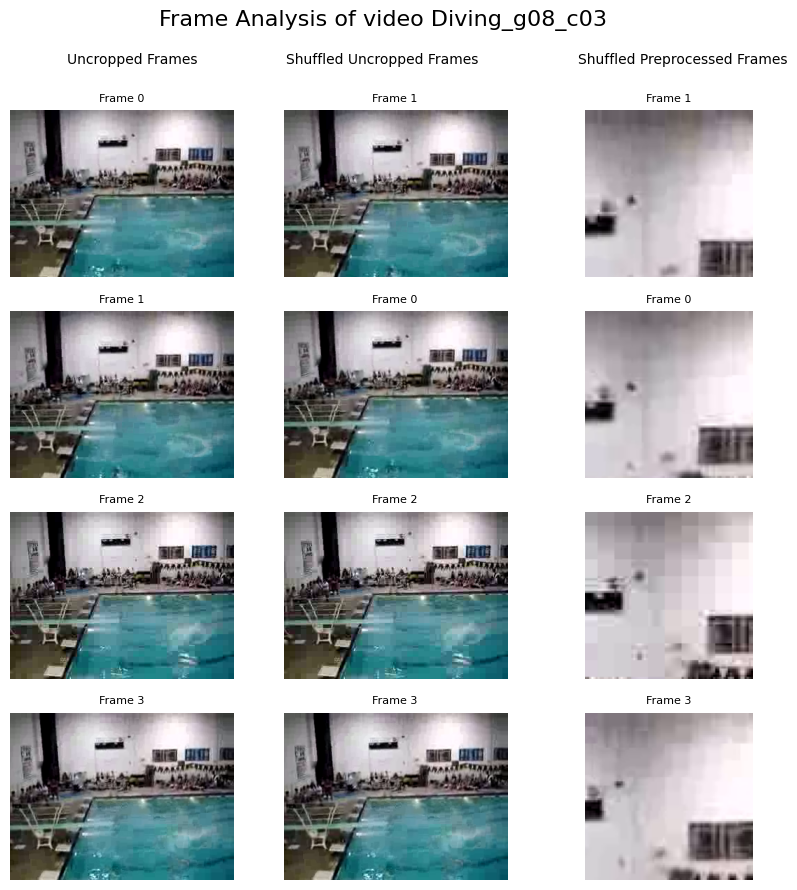

In [22]:
def test_temporal_four(temporal_four, n):
    input_frames, frame_order_label, action_label, video_name, frames_canonical_order, uncropped_frames = temporal_four[2]
    
    # Reorder the uncropped_frames based on frames_canonical_order
    ordered_uncropped_frames = uncropped_frames[frames_canonical_order]

    visualize_frames(input_frames, uncropped_frames, ordered_uncropped_frames, frames_canonical_order, video_name)
    #visualize_optical_flow(flows, indices) # TODO add method to get_flows&indices

def visualize_frames(input_frames, uncropped_frames, ordered_uncropped_frames, frames_canonical_order, video_name):
    # Create a figure and a grid of subplots with an extra row for the column titles
    fig, axs = plt.subplots(4, 3, figsize=(10, 10))

    for i, (frame, uncropped_frame, ordered_frame) in enumerate(zip(input_frames, uncropped_frames, ordered_uncropped_frames)):
        frame = frame.numpy()
        uncropped_frame = uncropped_frame.numpy()
        ordered_frame = ordered_frame.numpy()

        axs[i, 0].imshow(ordered_frame)
        axs[i, 0].set_title(f'Frame {i}', fontsize=8)
        axs[i, 0].axis('off')

        axs[i, 1].imshow(uncropped_frame)
        axs[i, 1].set_title(f'Frame {frames_canonical_order[i]}', fontsize=8)
        axs[i, 1].axis('off')

        axs[i, 2].imshow(frame)
        axs[i, 2].set_title(f'Frame {frames_canonical_order[i]}', fontsize=8)
        axs[i, 2].axis('off')

    # Set a common title for the entire plot
    fig.suptitle(f'Frame Analysis of video {video_name}', fontsize=16)

    # Define the titles for each column
    column_titles = ['Uncropped Frames', 'Shuffled Uncropped Frames', 'Shuffled Preprocessed Frames']

    # Set the column titles manually using the text function
    fig.text(0.25, 0.93, column_titles[0], ha='center', va='center', fontsize=10)
    fig.text(0.5, 0.93, column_titles[1], ha='center', va='center', fontsize=10)
    fig.text(0.8, 0.93, column_titles[2], ha='center', va='center', fontsize=10)

    plt.show()

def visualize_optical_flow(flows, indices):
    # Reorder the flows based on indices
    flows = [flows[i] for i in indices[:-1]]

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

    # Visualize the optical flow
    for i in range(3):
        flow = flows[i]
        flow = flow.numpy()
        hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
        hsv[...,1] = 255

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        # New code
        mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        mag = np.uint8(mag)
        hsv[...,2] = mag
        rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        im = axs[i].imshow(rgb)
        axs[i].set_title(f'Optical flow from frame {i} to its next', fontsize=10)
        axs[i].axis('off')

        # Add a color bar
        fig.colorbar(im, ax=axs[i], orientation='vertical')
        
    # Display the figure with the subplots
    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_load = 6
video_dataset = PreparedDataset(videos, trainval='train')
temporal_four = PreprocessedTemporalFourData(video_dataset, trainval='train')
test_temporal_four(temporal_four, amount_of_videos_to_load)

### Create Validation Set

In [19]:
# TODO: If deemed necessary: implement the split_data function to split the data into training and validation sets in order to finetune the hyperparameters

def split_data(dataset, split_ratio=0.8):
    # Calculate the number of samples in the training set
    train_size = int(split_ratio * len(dataset.predata_train))

    # Split the data
    train_data = dataset.predata_train[:train_size]
    validation_data = dataset.predata_train[train_size:]

    # Split the labels
    train_labels = dataset.action_labels_train[:train_size]
    validation_labels = dataset.action_labels_train[train_size:]

    # Split the video names
    train_video_names = dataset.video_names_train[:train_size]
    validation_video_names = dataset.video_names_train[train_size:]

    return train_data, train_labels, train_video_names, validation_data, validation_labels, validation_video_names

# Usage:
#train_data, train_labels, train_video_names, validation_data, validation_labels, validation_video_names = split_data(video_dataset)

### train_opn

In [27]:
class CustomOPN(nn.Module):
    def __init__(self):
        super(CustomOPN, self).__init__()

        # 1. FEATURE EXTRACTION
        # Processes the input frames and extracts features, before flattening output to next stage.
        self.conv_layers = nn.Sequential(
        nn.Conv2d(4*3, 96, kernel_size=11, stride=4, padding=0),  # accepting frames*channels as input
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # 2. PAIRWISE FEATURE EXTRACTION:
        # fc6 layer processes flattened output, splits it into four parts, 
        # and concatenates pairs to form new feature vectors. These vectors are then processed by the fc7 layers.
        self.fc6 = nn.Linear(256 * 1 * 1, 1024)  # Assuming the input size from conv2d is (256, 1, 1)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout(0.5)

        # The fc7 layers process the pairwise features
        self.fc7_layers = nn.ModuleList()
        for i in range(6):
            self.fc7_layers.append(nn.Sequential(
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5)
            ))

        # 3. ORDER PREDICTION:
        # fc8 layer processes concatenated feature vectors from previous stage and outputs final predictions.
        self.fc8 = nn.Linear(512*6, 12)  # 6 is the number of concatenated layers

    def forward(self, x):
        # Feature extraction
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pairwise feature extraction
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.drop6(x)
        x1, x2, x3, x4 = x.chunk(4, dim=1)  # Slice the tensor into 4 parts
        x_concat = [torch.cat((x1, x2), dim=1), torch.cat((x2, x3), dim=1), torch.cat((x3, x4), dim=1),
                torch.cat((x1, x3), dim=1), torch.cat((x2, x4), dim=1), torch.cat((x1, x4), dim=1)]
        
        out = []
        for i in range(6):
            out_i = self.fc7_layers[i](x_concat[i])
            out.append(out_i)

        # Order prediction. Predicts the order of the frames.
        out = torch.cat(out, dim=1)  # Concatenate along the channel dimension
        #print(out.shape)
        out = self.fc8(out)
        return out
    
#Initialize the model
model = CustomOPN()
criterion = nn.CrossEntropyLoss()

#Setting optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1) #TODO make it milestones=[130000, 170000]

# Create data loaders
temporal_four = PreprocessedTemporalFourData(video_dataset, trainval='train')
train_loader = torch.utils.data.DataLoader(temporal_four, batch_size=32, shuffle=True)

# Assuming validation_data is your validation dataset
#validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=False) TODO add validation data

# Number of batches in the DataLoader
num_batches = len(train_loader)
print(f'Number of batches: {num_batches}')

# Size of a single batch
for batch in train_loader:
    print(f'Size of input batch: {batch[0].size()}')
    print(f'Size of output batch: {batch[1].size()}')

# Training loop
epoch_amount = 10

for epoch in range(epoch_amount): # max_iter, TODO make it 17000
    # Training phase
    print('Starting Training')
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, frame_order_labels, action_labels, _, _, _ in train_loader:
        print('Running train loader')
        # Convert inputs to float
        inputs = inputs.to(torch.float32)

        #TODO check if this is correct
        inputs = inputs.permute(0, 1, 4, 2, 3)  # Change the order of dimensions to (batch_size, frames, channels, height, width)
        inputs = inputs.contiguous().view(-1, inputs.shape[1]*inputs.shape[2], inputs.shape[3], inputs.shape[4])  # Concatenate frames and channels

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        #print(outputs)

        # Get predicted class labels
        _, predicted_labels = torch.max(outputs, 1)
        #print("Predicted labels: ", predicted_labels)
                
        # Calculate loss
        loss = criterion(outputs, frame_order_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predicted_labels == frame_order_labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    print(f'Epoch {epoch}/{epoch_amount-1}, Loss: {epoch_loss}, Accuracy: {epoch_acc}')
    
    # Every 10000 iterations, save a snapshot of the model
    #if epoch % 10000 == 0:
    # At the end of each epoch, save the model's weights
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pt')

    # TODO add validation phase to possibly fine-tune the model's parameters.
    # Validation phase
    #model.eval()
    #correct = 0
    #total = 0
    #with torch.no_grad():
    #    for inputs, frame_labels, video_labels in validation_loader:
    #        # Convert inputs to float
    #        inputs = inputs.to(torch.float32)
    #        outputs = model(inputs)
    #        _, predicted = torch.max(outputs.data, 1)
    #        total += frame_labels.size(0)
    #        correct += (predicted == frame_labels).sum().item()
    #print(f'Epoch {epoch}, Accuracy: {100 * correct / total}%')
    
    # Step the learning rate scheduler
    scheduler.step()

Number of batches: 4
Size of input batch: torch.Size([32, 4, 80, 80, 3])
Size of output batch: torch.Size([32])
Size of input batch: torch.Size([32, 4, 80, 80, 3])
Size of output batch: torch.Size([32])
Size of input batch: torch.Size([32, 4, 80, 80, 3])
Size of output batch: torch.Size([32])
Size of input batch: torch.Size([9, 4, 80, 80, 3])
Size of output batch: torch.Size([9])
Starting Training
Running train loader
Running train loader
Running train loader
Running train loader
Epoch 0/9, Loss: 2.609530680520194, Accuracy: 0.09523809523809523
Starting Training
Running train loader
Running train loader
Running train loader
Running train loader
Epoch 1/9, Loss: 2.9178687822251095, Accuracy: 0.09523809523809523
Starting Training


KeyboardInterrupt: 

### Evaluate the model

In [ ]:
# Load the trained model
model_path = f'model_epoch_{epoch_amount-1}.pt'  # replace with your model path
model = CustomOPN()
model.load_state_dict(torch.load(model_path))
model.eval()

# Create a DataLoader for the test data
test_dataset = PreprocessedTemporalFourData(video_dataset, trainval='test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the running accuracy
running_corrects = 0

# Iterate over the test data
for inputs, frame_order_labels, action_labels, video_name, _ in test_loader:
    # Convert inputs to float
    inputs = inputs.to(torch.float32)

    # Change the order of dimensions to (batch_size, frames, channels, height, width)
    inputs = inputs.permute(0, 1, 4, 2, 3)
    # Concatenate frames and channels
    inputs = inputs.contiguous().view(-1, inputs.shape[1]*inputs.shape[2], inputs.shape[3], inputs.shape[4])

    # Make predictions
    outputs = model(inputs)

    # Get predicted class labels
    _, predicted_labels = torch.max(outputs, 1)

    # Update the running accuracy
    running_corrects += torch.sum(predicted_labels == frame_order_labels.data)

# Calculate the final accuracy
accuracy = running_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {accuracy}')

NameError: name 'epoch_amount' is not defined

### Visualize Network

In [ ]:
from torchviz import make_dot

# Assuming `inputs` is a batch of your input data
inputs = torch.randn(1, 4, 80, 80, 3)  # Adjust the size as needed

model = CustomOPN()

# Permute the dimensions to (batch_size, frames, channels, height, width)
inputs = inputs.permute(0, 1, 4, 2, 3)

# Flatten the frames and channels dimensions
inputs = inputs.contiguous().view(-1, inputs.shape[1]*inputs.shape[2], inputs.shape[3], inputs.shape[4])

# Ensure there is more than one value per channel
if inputs.shape[0] == 1:
    inputs = inputs.repeat(2, 1, 1, 1)

outputs = model(inputs)

# Create the graph
dot = make_dot(outputs, params=dict(model.named_parameters()))

# Display the graph
dot.view()

Error: Could not open "Digraph.gv.pdf" for writing : Permission denied


CalledProcessError: Command '[WindowsPath('dot'), '-Kdot', '-Tpdf', '-O', 'Digraph.gv']' returned non-zero exit status 1. [stderr: b'Error: Could not open "Digraph.gv.pdf" for writing : Permission denied\r\n']

### solver_opn